In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

In [3]:
# Select the columns that are listed above
df = df[['sample', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

# Remove "_TCRB" part from the sample name
df['sample'] = df['sample'].map(lambda x: x.rstrip('_TCRB'))

# Create a dataframe with reads count for each sample
df_reads = df.groupby(['sample', 'hospitalized']).agg({'#count': 'sum'}).reset_index().rename(columns={'#count': "count"})

# Calculate clonotype frequency
df = pd.merge(df, df_reads, how='outer', on=['sample','hospitalized']).fillna(0)
df['freq'] = df['#count'] / (df['count'] * 1.0)
df.fillna(0, inplace=True)

# Create a dataframe with clonotype count for each sample
df_diversity = df.groupby(['sample', 'hospitalized'], sort=False).size().reset_index(name='clonotype_count')

# Add clonotype count of each sample as a column to create a new dataframe
df = pd.merge(df, df_diversity, on=['sample', 'hospitalized'])

df

,sample,#count,cdr3aa,cdr3nt,v,d,j,hospitalized,count,freq,clonotype_count
0,6232BW,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.008268,218977
1,6232BW,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.006906,218977
2,6232BW,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True,439782,0.005214,218977
3,6232BW,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True,439782,0.004457,218977
4,6232BW,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True,439782,0.004311,218977
...,...,...,...,...,...,...,...,...,...,...,...
15061643,1566265BW,1,CSVEDLRGGYTF,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,TCRBV29-01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061644,1566265BW,1,CASGRRGDYGYTF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061645,1566265BW,1,CASSWTGNSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01,TCRBJ01-06*02,False,758231,0.000001,453526
15061646,1566265BW,1,CASSLDWTEYYEQYF,CAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...,TCRBV11-02*01,TCRBD01-01*01,TCRBJ02-07*01,False,758231,0.000001,453526


Diversity analysis 1 - Shannon-Wiener index [shannon_wiener_index]

In [4]:
# Calculation step 1
df['shannon_index'] = -(df['freq']*np.log(df['freq']))

# Calculation step 2
df_shannon = df.groupby(['sample', 'hospitalized']).agg(
    {'shannon_index': 'sum'}).reset_index().rename(columns={'': "shannon_index"})

# Calculation step 3, Shannon-Wienex index is shown in the shannon_wiener_index column
df_shannon['shannon_wiener_index'] = np.exp(df_shannon['shannon_index'])
df_shannon_index = df_shannon[[
    'sample', 'hospitalized', 'shannon_wiener_index']]

Diversity analysis 2 - Normalized Shannon-Wiener index [normalized_shannon_wiener_index]

In [5]:
# Calculation step 1 - merge df_shannon and df_diversity (which contains clonotype counts)
df_shannon = pd.merge(df_shannon, df_diversity, on=[
                      'sample', 'hospitalized'])

# Calculation step 2 - calculate normalized Shannon-Wienex index, it is shown in the normalized_shannon_wiener_index column
df_shannon['normalized_shannon_wiener_index'] = df_shannon['shannon_index'] / \
    np.log(df_shannon['clonotype_count'])

df_norm_shannon = df_shannon[['sample', 'hospitalized',
                              'shannon_wiener_index', 'normalized_shannon_wiener_index']]

Diversity analysis 3 - Inverse Simpson index [inverse_simpson_index]

In [6]:
# Calculation step 1
df['simpson_index'] = (df['freq']**2)

# Calculation step 2
df_simpson = df.groupby(['sample', 'hospitalized']).agg(
    {'simpson_index': 'sum'}).reset_index().rename(columns={'': "simpson_index"})

# Calculation step 3, Inverse Simpson index is shown in the inverse_simpson_index column
df_simpson['inverse_simpson_index'] = 1/df_simpson['simpson_index']

Diversity analysis 4 - Gini Simpson index [gini_simpson_index]


In [7]:
df_simpson['gini_simpson_index'] = 1-df_simpson['simpson_index']

Diversity analysis 5 - D50 index [D50_index]


In [8]:
# Create an empty dataframe for storing results
df_D50 = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    # Sort the sample clonotypes by frequency in descending order
    df_temp = df_temp.sort_values(by='freq', ascending=False)

    # Create a column to store the order
    df_temp['clonotype_number'] = np.arange(df_temp.shape[0])+1

    # Compute and store the cumulative sum of the frequencies
    df_temp['accum_freq'] = df_temp['freq'].cumsum()

    # Find out the first accumulated frequency that is above 50%
    df_temp = df_temp.loc[(df_temp['accum_freq'] >= 0.5)
                          & (df_temp['accum_freq'] <= 0.6)]
    df_temp = df_temp.head(1)

    # Calculate D50 index and store in the result dataframe
    df_temp = df_temp.head(1)
    df_temp['D50_index'] = df_temp['clonotype_number'] / \
        df_temp['clonotype_count']*100
    df_D50 = pd.concat([df_D50, df_temp])

df_D50 = df_D50[['sample', 'hospitalized', 'D50_index']]

Diversity analysis 6 - Chao1 estimate [chao1] and standard deviation [chao1_SD]







In [9]:
# Create an empty dataframe for storing results
df_chao1 = pd.DataFrame()

# Get the columns needed for calculation from df
df1 = df[['sample', '#count', 'clonotype_count', 'hospitalized']]

# Create a list of the sample names
samples = set(df1['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df1.loc[df1['sample'] == sample]

    # Count singleton in the sample
    singleton = len(df_temp.loc[df_temp['#count'] == 1])

    # Count doubleton in the sample
    doubleton = len(df_temp.loc[df_temp['#count'] == 2])

    # Calculate Chao1 estimate
    chao1 = int(df_temp['clonotype_count'].values[0]) + \
        ((singleton * (singleton-1))/(2*(doubleton+1)))
    df_temp['chao1'] = chao1

    # Calculate Chao1 estimate standard deviation
    step1 = 1/4*((singleton/doubleton)**4)
    step2 = (singleton/doubleton)**3
    step3 = 1/2*((singleton/doubleton)**2)
    step4 = doubleton * (step1+step2+step3)
    df_temp['chao1_SD'] = step4**(1/2)

    # Store the results in the result dataframe
    df_chao1 = pd.concat([df_chao1, df_temp], axis=0, sort=False)

    # Remove the duplicates results in the result dataframe
    df_chao1 = df_chao1[['sample', 'hospitalized', 'chao1', 'chao1_SD']]
    df_chao1 = df_chao1.drop_duplicates(subset=['sample'], keep='first')

Diversity analysis 7 - Gini coefficient [gini_coefficient]

In [10]:
# Create an empty dataframe for storing results
df_gini = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    def gini(list_of_values):
        sorted_list = sorted(list_of_values)
        height, area = 0, 0
        for value in sorted_list:
            height += value
            area += height - value / 2.
        fair_area = height * len(list_of_values) / 2.
        return (fair_area - area) / fair_area

    # Calculate gini coefficient
    df_temp['gini_coefficient'] = gini(df_temp['freq'])

    # Store the results in the result dataframe
    df_gini = pd.concat([df_gini, df_temp], sort=False)

    # Remove the duplicates results in the result dataframe
    df_gini = df_gini[['sample', 'hospitalized', 'gini_coefficient']]
    df_gini = df_gini.drop_duplicates(subset=['sample'], keep='first')

Summary table for the diversity analysis

In [11]:
# Create a dataframe that combines all the diversity analysis
dfs = [df_norm_shannon, df_simpson, df_D50, df_chao1, df_gini]

df_combined = pd.merge(dfs[0], dfs[1], left_on=['sample', 'hospitalized'], right_on=[
                       'sample', 'hospitalized'], how='outer')

for d in dfs[2:]:
    df_combined = pd.merge(df_combined, d, left_on=['sample', 'hospitalized'], right_on=[
                           'sample', 'hospitalized'], how='outer')

df_combined

,sample,hospitalized,shannon_wiener_index,normalized_shannon_wiener_index,simpson_index,inverse_simpson_index,gini_simpson_index,D50_index,chao1,chao1_SD,gini_coefficient
0,1132289BW,False,195624.753715,0.948760,0.000072,13793.733033,0.999928,24.807080,2.084775e+06,11410.373284,0.319436
1,1222568BW,False,117968.199335,0.920178,0.000225,4435.260349,0.999775,14.015593,1.502319e+06,8096.333443,0.412047
2,1337122BW,False,88730.200439,0.873194,0.004973,201.080546,0.995027,24.504553,2.682283e+06,13306.917361,0.329197
3,1445BW,False,72593.018417,0.856409,0.002108,474.383015,0.997892,10.833013,2.569078e+06,12316.618071,0.439525
4,1564208BW,False,155312.662318,0.935018,0.000138,7230.534562,0.999862,17.893615,1.703006e+06,8928.384316,0.370510
5,1566265BW,False,104041.059178,0.886964,0.000848,1179.689345,0.999152,16.407218,2.662749e+06,13646.111790,0.391194
6,1566319BW,False,229457.310377,0.952698,0.000148,6773.287156,0.999852,27.341568,2.218496e+06,11090.841381,0.296313
7,1566426BW,False,170911.215089,0.960795,0.000124,8045.826969,0.999876,32.889830,1.864089e+06,13030.216495,0.244315
8,1566449BW,False,179446.663362,0.944327,0.000247,4041.462330,0.999753,25.829947,1.932286e+06,10429.199800,0.310889
9,1566486BW,False,231158.923514,0.937949,0.001170,854.929286,0.998830,33.890228,4.006665e+06,21730.358941,0.237706


## Figure5a - Shannon-Wiener index

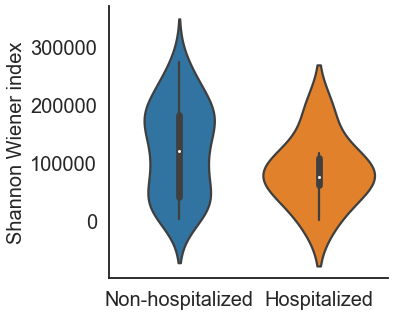

In [12]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.violinplot(x=attribute, y='shannon_wiener_index', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('Shannon Wiener index', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5a.png",bbox_inches="tight")

plt.show()

## Figure5b - Normalized Shannon-Wiener index 

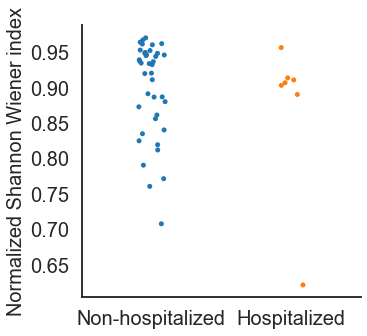

In [13]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.stripplot(x=attribute, y='normalized_shannon_wiener_index', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('Normalized Shannon Wiener index', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5b.png",bbox_inches="tight")

plt.show()

## Figure5c - Inverse Simpson index

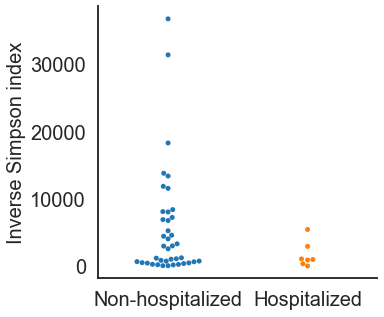

In [14]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.swarmplot(x=attribute, y='inverse_simpson_index', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('Inverse Simpson index', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5c.png",bbox_inches="tight")

plt.show()

## Figure5d - Gini Simpson index 

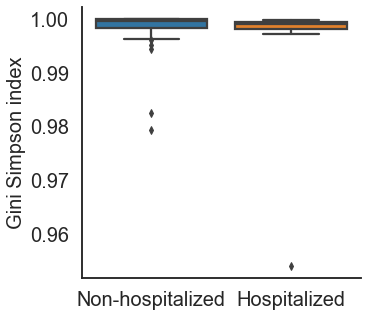

In [15]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxplot(x=attribute, y='gini_simpson_index', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('Gini Simpson index', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5d.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5d.png",bbox_inches="tight")

plt.show()

## Figure5e - D50 index

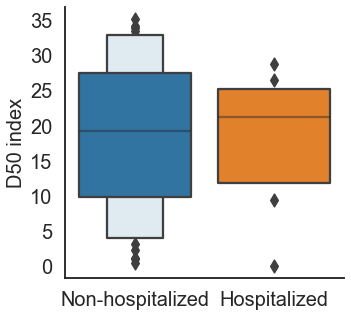

In [16]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxenplot(x=attribute, y='D50_index', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('D50 index', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5e.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5e.png",bbox_inches="tight")

plt.show()

## Figure5f - Chao1 estimate

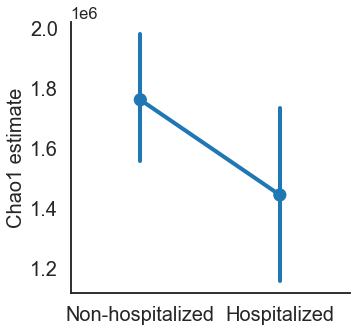

In [17]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.pointplot(x=attribute, y='chao1', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('Chao1 estimate', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5f.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5f.png",bbox_inches="tight")

plt.show()

## Figure5g - Gini coefficient

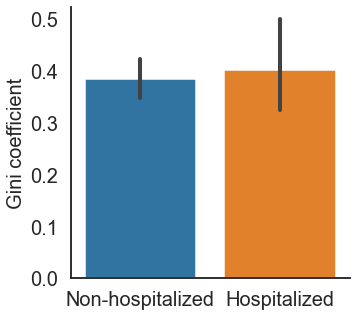

In [18]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.barplot(x=attribute, y='gini_coefficient', data=df_combined)

ax.set(xlabel=None)
ax.set_ylabel('Gini coefficient', fontsize=20)
xlabels = ['Non-hospitalized','Hospitalized']
ax.set_xticklabels(xlabels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

plt.savefig("../figures/supplementary/figureS5g.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5g.png",bbox_inches="tight")

plt.show()